In [1]:
import sys

!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install mxnet

     |████████████████████████████████| 47.3 MB 18.5 MB/s            


In [2]:
bucket = "test-1-11jan1031am"  # custom bucket name.
prefix = "DEMO-ObjectDetection-birds"

In [3]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::355035392465:role/service-role/AmazonSageMaker-ExecutionRole-20211114T122978


In [4]:
import os
import urllib.request


def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

In [7]:
%%time
# download('http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz')
# CalTech's download is (at least temporarily) unavailable since August 2020.

# Can now use one made available by fast.ai .
download("https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz")

CPU times: user 5.8 s, sys: 3.08 s, total: 8.87 s
Wall time: 3min 43s


In [8]:
%%time
# Clean up prior version of the downloaded dataset if you are running this again
# !rm -rf CUB_200_2011

# Unpack and then remove the downloaded compressed tar file
!gunzip -c ./CUB_200_2011.tgz | tar xopf -
!rm CUB_200_2011.tgz

CPU times: user 136 ms, sys: 54.3 ms, total: 191 ms
Wall time: 10.7 s


In [5]:
import pandas as pd
import cv2
import boto3
import json

runtime = boto3.client(service_name="runtime.sagemaker")

import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_SPLIT = False
SAMPLE_ONLY = True
FLIP = False

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
CLASSES = [17, 36, 47, 68, 73]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]

RESIZE_SIZE = 256

BASE_DIR = "CUB_200_2011/"
IMAGES_DIR = BASE_DIR + "images/"

CLASSES_FILE = BASE_DIR + "classes.txt"
BBOX_FILE = BASE_DIR + "bounding_boxes.txt"
IMAGE_FILE = BASE_DIR + "images.txt"
LABEL_FILE = BASE_DIR + "image_class_labels.txt"
SIZE_FILE = BASE_DIR + "sizes.txt"
SPLIT_FILE = BASE_DIR + "train_test_split.txt"

TRAIN_LST_FILE = "birds_ssd_train.lst"
VAL_LST_FILE = "birds_ssd_val.lst"

if SAMPLE_ONLY:
    TRAIN_LST_FILE = "birds_ssd_sample_train.lst"
    VAL_LST_FILE = "birds_ssd_sample_val.lst"

TRAIN_RATIO = 0.8
CLASS_COLS = ["class_number", "class_id"]
IM2REC_SSD_COLS = [
    "header_cols",
    "label_width",
    "zero_based_id",
    "xmin",
    "ymin",
    "xmax",
    "ymax",
    "image_file_name",
]

In [6]:
def show_species(species_id):
    _im_list = !ls $IMAGES_DIR/$species_id

    NUM_COLS = 6
    IM_COUNT = len(_im_list)

    print('Species ' + species_id + ' has ' + str(IM_COUNT) + ' images.')

    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(8.0, 16.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + species_id + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()
    plt.show()

    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

In [7]:
classes_df = pd.read_csv(CLASSES_FILE, sep=" ", names=CLASS_COLS, header=None)
criteria = classes_df["class_number"].isin(CLASSES)
classes_df = classes_df[criteria]
print(classes_df.to_csv(columns=["class_id"], sep="\t", index=False, header=False))

017.Cardinal
036.Northern_Flicker
047.American_Goldfinch
068.Ruby_throated_Hummingbird
073.Blue_Jay



Species 017.Cardinal has 57 images.


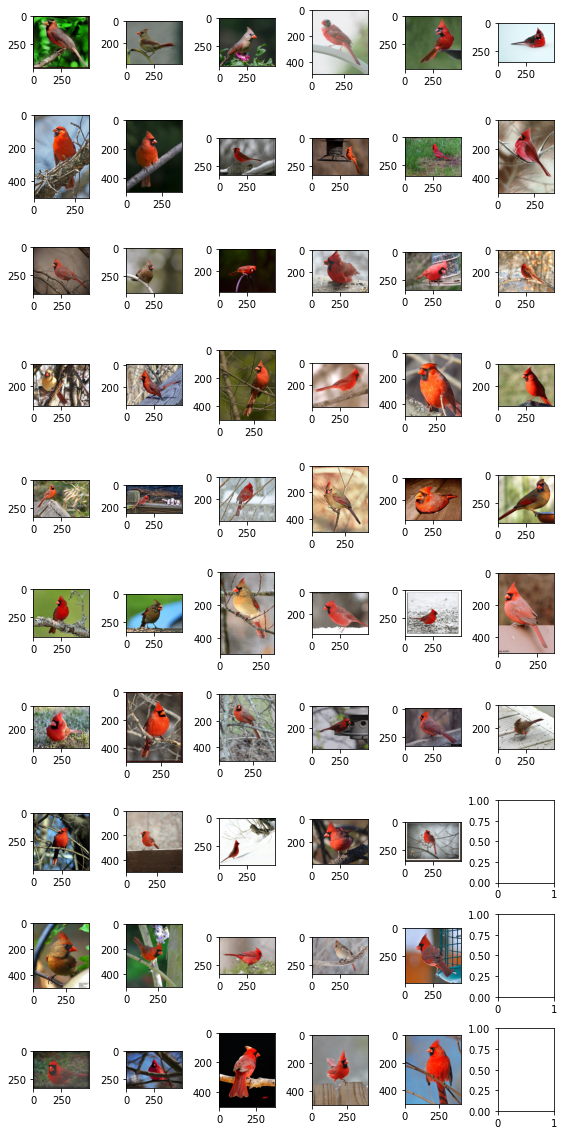

In [8]:
show_species("017.Cardinal")

In [9]:
%%time
SIZE_COLS = ["idx", "width", "height"]


def gen_image_size_file():
    print("Generating a file containing image sizes...")
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    rows_list = []
    idx = 0
    for i in images_df["image_file_name"]:
        # TODO: add progress bar
        idx += 1
        img = cv2.imread(IMAGES_DIR + i)
        dimensions = img.shape
        height = img.shape[0]
        width = img.shape[1]
        image_dict = {"idx": idx, "width": width, "height": height}
        rows_list.append(image_dict)

    sizes_df = pd.DataFrame(rows_list)
    print("Image sizes:\n" + str(sizes_df.head()))

    sizes_df[SIZE_COLS].to_csv(SIZE_FILE, sep=" ", index=False, header=None)


gen_image_size_file()

Generating a file containing image sizes...
Image sizes:
   idx  width  height
0    1    500     335
1    2    500     336
2    3    500     347
3    4    415     500
4    5    331     380
CPU times: user 47.2 s, sys: 1.6 s, total: 48.8 s
Wall time: 4min 5s


In [10]:
def split_to_train_test(df, label_column, train_frac=0.8):
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    labels = df[label_column].unique()
    for lbl in labels:
        lbl_df = df[df[label_column] == lbl]
        lbl_train_df = lbl_df.sample(frac=train_frac)
        lbl_test_df = lbl_df.drop(lbl_train_df.index)
        print(
            "\n{}:\n---------\ntotal:{}\ntrain_df:{}\ntest_df:{}".format(
                lbl, len(lbl_df), len(lbl_train_df), len(lbl_test_df)
            )
        )
        train_df = train_df.append(lbl_train_df)
        test_df = test_df.append(lbl_test_df)
    return train_df, test_df


def gen_list_files():
    # use generated sizes file
    sizes_df = pd.read_csv(
        SIZE_FILE, sep=" ", names=["image_pretty_name", "width", "height"], header=None
    )
    bboxes_df = pd.read_csv(
        BBOX_FILE,
        sep=" ",
        names=["image_pretty_name", "x_abs", "y_abs", "bbox_width", "bbox_height"],
        header=None,
    )
    split_df = pd.read_csv(
        SPLIT_FILE, sep=" ", names=["image_pretty_name", "is_training_image"], header=None
    )
    print(IMAGE_FILE)
    images_df = pd.read_csv(
        IMAGE_FILE, sep=" ", names=["image_pretty_name", "image_file_name"], header=None
    )
    print("num images total: " + str(images_df.shape[0]))
    image_class_labels_df = pd.read_csv(
        LABEL_FILE, sep=" ", names=["image_pretty_name", "class_id"], header=None
    )

    # Merge the metadata into a single flat dataframe for easier processing
    full_df = pd.DataFrame(images_df)
    full_df.reset_index(inplace=True)
    full_df = pd.merge(full_df, image_class_labels_df, on="image_pretty_name")
    full_df = pd.merge(full_df, sizes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, bboxes_df, on="image_pretty_name")
    full_df = pd.merge(full_df, split_df, on="image_pretty_name")
    full_df.sort_values(by=["index"], inplace=True)

    # Define the bounding boxes in the format required by SageMaker's built in Object Detection algorithm.
    # the xmin/ymin/xmax/ymax parameters are specified as ratios to the total image pixel size
    full_df["header_cols"] = 2  # one col for the number of header cols, one for the label width
    full_df["label_width"] = 5  # number of cols for each label: class, xmin, ymin, xmax, ymax
    full_df["xmin"] = full_df["x_abs"] / full_df["width"]
    full_df["xmax"] = (full_df["x_abs"] + full_df["bbox_width"]) / full_df["width"]
    full_df["ymin"] = full_df["y_abs"] / full_df["height"]
    full_df["ymax"] = (full_df["y_abs"] + full_df["bbox_height"]) / full_df["height"]

    # object detection class id's must be zero based. map from
    # class_id's given by CUB to zero-based (1 is 0, and 200 is 199).

    if SAMPLE_ONLY:
        # grab a small subset of species for testing
        criteria = full_df["class_id"].isin(CLASSES)
        full_df = full_df[criteria]

    unique_classes = full_df["class_id"].drop_duplicates()
    sorted_unique_classes = sorted(unique_classes)

    id_to_zero = {}
    i = 0.0
    for c in sorted_unique_classes:
        id_to_zero[c] = i
        i += 1.0

    full_df["zero_based_id"] = full_df["class_id"].map(id_to_zero)

    full_df.reset_index(inplace=True)

    # use 4 decimal places, as it seems to be required by the Object Detection algorithm
    pd.set_option("display.precision", 4)

    train_df = []
    val_df = []

    if RANDOM_SPLIT:
        # split into training and validation sets
        train_df, val_df = split_to_train_test(full_df, "class_id", TRAIN_RATIO)

        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)
    else:
        train_df = full_df[(full_df.is_training_image == 1)]
        train_df[IM2REC_SSD_COLS].to_csv(TRAIN_LST_FILE, sep="\t", float_format="%.4f", header=None)

        val_df = full_df[(full_df.is_training_image == 0)]
        val_df[IM2REC_SSD_COLS].to_csv(VAL_LST_FILE, sep="\t", float_format="%.4f", header=None)

    print("num train: " + str(train_df.shape[0]))
    print("num val: " + str(val_df.shape[0]))
    return train_df, val_df

In [11]:
train_df, val_df = gen_list_files()

CUB_200_2011/images.txt
num images total: 11788
num train: 150
num val: 147


In [12]:
!tail -3 $TRAIN_LST_FILE

291	2	5	4.0000	0.4080	0.1527	0.9880	0.8728	073.Blue_Jay/Blue_Jay_0048_62433.jpg
294	2	5	4.0000	0.2500	0.1455	0.8260	0.8303	073.Blue_Jay/Blue_Jay_0086_63394.jpg
296	2	5	4.0000	0.2960	0.5400	0.8160	0.8460	073.Blue_Jay/Blue_Jay_0074_63487.jpg


In [13]:
!python im2rec.py --resize $RESIZE_SIZE --pack-label birds_ssd_sample $BASE_DIR/images/

Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_val.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.13028335571289062  count: 0
Creating .rec file from /home/ec2-user/SageMaker/birds_ssd_sample_train.lst in /home/ec2-user/SageMaker
multiprocessing not available, fall back to single threaded encoding
time: 0.006696939468383789  count: 0


In [14]:
# Upload the RecordIO files to train and validation channels
train_channel = prefix + "/train"
validation_channel = prefix + "/validation"

sess.upload_data(path="birds_ssd_sample_train.rec", bucket=bucket, key_prefix=train_channel)
sess.upload_data(path="birds_ssd_sample_val.rec", bucket=bucket, key_prefix=validation_channel)

s3_train_data = "s3://{}/{}".format(bucket, train_channel)
s3_validation_data = "s3://{}/{}".format(bucket, validation_channel)

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, "object-detection", repo_version="latest")
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/object-detection:1


In [16]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)

In [17]:
od_model = sagemaker.estimator.Estimator(
    training_image,
    role,
    train_instance_count=1,
    train_instance_type="ml.p3.2xlarge",
    train_volume_size=50,
    train_max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
def set_hyperparameters(num_epochs, lr_steps):
    num_classes = classes_df.shape[0]
    num_training_samples = train_df.shape[0]
    print("num classes: {}, num training images: {}".format(num_classes, num_training_samples))

    od_model.set_hyperparameters(
        base_network="resnet-50",
        use_pretrained_model=1,
        num_classes=num_classes,
        mini_batch_size=16,
        epochs=num_epochs,
        learning_rate=0.001,
        lr_scheduler_step=lr_steps,
        lr_scheduler_factor=0.1,
        optimizer="sgd",
        momentum=0.9,
        weight_decay=0.0005,
        overlap_threshold=0.5,
        nms_threshold=0.45,
        image_shape=512,
        label_width=350,
        num_training_samples=num_training_samples,
    )

In [19]:
set_hyperparameters(100, "33,67")

num classes: 5, num training images: 150


In [20]:
train_data = sagemaker.session.s3_input(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.session.s3_input(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [21]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2022-01-13 06:50:44 Starting - Starting the training job...
2022-01-13 06:51:10 Starting - Preparing the instances for trainingProfilerReport-1642056644: InProgress
.........
2022-01-13 06:52:45 Downloading - Downloading input data
2022-01-13 06:52:45 Training - Downloading the training image......
2022-01-13 06:53:45 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/13/2022 06:53:49 INFO 140305229461312 integration.py:636] worker started
[01/13/2022 06:53:49 INFO 140305229461312] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'base_network': 'vgg-16', 'use_pretrained_model': '0', 'num_classes': '', 'mini_batch_size': '32', 'epochs': '30', 'learning_rate': '0.001', 'lr_scheduler_step': '', 'lr_scheduler_factor': '0.1', 'optimizer': 'sgd', 'momentum': '0.9', 'weight_decay': '0.0005', 'overlap_threshold': '0.5', 'nms_threshold': '0.45', 'num_training_samples':

In [22]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

client = boto3.client("logs")
BASE_LOG_NAME = "/aws/sagemaker/TrainingJobs"


def plot_object_detection_log(model, title):
    logs = client.describe_log_streams(
        logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name
    )
    cw_log = client.get_log_events(
        logGroupName=BASE_LOG_NAME, logStreamName=logs["logStreams"][0]["logStreamName"]
    )

    mAP_accs = []
    for e in cw_log["events"]:
        msg = e["message"]
        if "validation mAP <score>=" in msg:
            num_start = msg.find("(")
            num_end = msg.find(")")
            mAP = msg[num_start + 1 : num_end]
            mAP_accs.append(float(mAP))

    print(title)
    print("Maximum mAP: %f " % max(mAP_accs))

    fig, ax = plt.subplots()
    plt.xlabel("Epochs")
    plt.ylabel("Mean Avg Precision (mAP)")
    (val_plot,) = ax.plot(range(len(mAP_accs)), mAP_accs, label="mAP")
    plt.legend(handles=[val_plot])
    ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.2f"))
    plt.show()

mAP tracking for job: object-detection-2022-01-13-06-50-44-245
Maximum mAP: 0.189983 


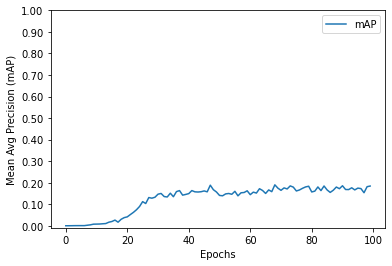

In [23]:
plot_object_detection_log(od_model, "mAP tracking for job: " + od_model._current_job_name)

In [24]:
%%time
object_detector = od_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!CPU times: user 130 ms, sys: 961 µs, total: 131 ms
Wall time: 3min 31s


In [25]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
    """
    visualize detections in one image
    Parameters:
    ----------
    img : numpy.array
        image, in bgr format
    dets : numpy.array
        ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
        each row is one object
    classes : tuple or list of str
        class names
    thresh : float
        score threshold
    """
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    img = mpimg.imread(img_file)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    num_detections = 0
    for det in dets:
        (klass, score, x0, y0, x1, y1) = det
        if score < thresh:
            continue
        num_detections += 1
        cls_id = int(klass)
        if cls_id not in colors:
            colors[cls_id] = (random.random(), random.random(), random.random())
        xmin = int(x0 * width)
        ymin = int(y0 * height)
        xmax = int(x1 * width)
        ymax = int(y1 * height)
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=colors[cls_id],
            linewidth=3.5,
        )
        plt.gca().add_patch(rect)
        class_name = str(cls_id)
        if classes and len(classes) > cls_id:
            class_name = classes[cls_id]
        print("{},{}".format(class_name, score))
        plt.gca().text(
            xmin,
            ymin - 2,
            "{:s} {:.3f}".format(class_name, score),
            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
            fontsize=12,
            color="white",
        )

    print("Number of detections: " + str(num_detections))
    plt.show()

In [37]:
OBJECT_CATEGORIES = classes_df["class_id"].values.tolist()


def show_bird_prediction(filename, ep, thresh=0.20):
    b = ""
    with open(filename, "rb") as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep, ContentType="image/jpeg", Body=b)
    results = endpoint_response["Body"].read()
    detections = json.loads(results)
    visualize_detection(filename, detections["prediction"], OBJECT_CATEGORIES, thresh)

In [27]:
!wget -q -O multi-goldfinch-1.jpg https://t3.ftcdn.net/jpg/01/44/64/36/500_F_144643697_GJRUBtGc55KYSMpyg1Kucb9yJzvMQooW.jpg
!wget -q -O northern-flicker-1.jpg https://upload.wikimedia.org/wikipedia/commons/5/5c/Northern_Flicker_%28Red-shafted%29.jpg
!wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
!wget -q -O blue-jay-1.jpg https://cdn12.picryl.com/photo/2016/12/31/blue-jay-bird-feather-animals-b8ee04-1024.jpg
!wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Number of detections: 0


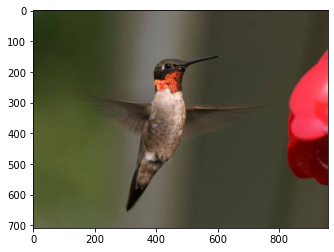

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Number of detections: 0


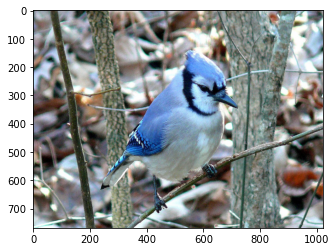

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Number of detections: 0


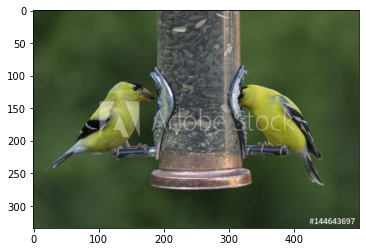

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


036.Northern_Flicker,0.3032550811767578
036.Northern_Flicker,0.24033671617507935
Number of detections: 2


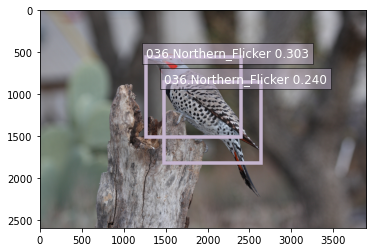

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


017.Cardinal,0.2695068120956421
017.Cardinal,0.22788959741592407
Number of detections: 2


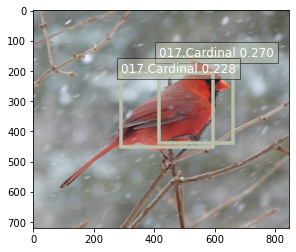

In [38]:
def test_model():
    show_bird_prediction("hummingbird-1.jpg", object_detector.endpoint)
    show_bird_prediction("blue-jay-1.jpg", object_detector.endpoint)
    show_bird_prediction("multi-goldfinch-1.jpg", object_detector.endpoint)
    show_bird_prediction("northern-flicker-1.jpg", object_detector.endpoint)
    show_bird_prediction("northern-cardinal-1.jpg", object_detector.endpoint)


test_model()

In [39]:
!wget -q -O blue-jay-cardinal-1.jpg https://cdn.birdwatchingdaily.com/2015/01/cardiandbluejay2.jpg

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


073.Blue_Jay,0.5521461367607117
017.Cardinal,0.5170294642448425
Number of detections: 2


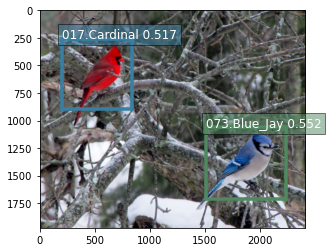

In [40]:
show_bird_prediction("blue-jay-cardinal-1.jpg", object_detector.endpoint)